# Homotopic optimal control of interplanetary spacecraft

## Dynamics

In [1]:
from sympy import *
init_printing()

In [2]:
# state variables
x, y, z, vx, vy, vz = symbols('x y z v_x v_y v_z', real=True)
m = symbols('m', real=True, nonnegative=True)

# position
p = Matrix([x, y, z])

# velocity
v = Matrix([vx, vy, vz])

# state
s = Matrix([p, v, [m]])
s.T

[x  y  z  vₓ  v_y  v_z  m]

In [3]:
# control parameters
um = symbols('u', real=True, positive=True)
ux, uy, uz =symbols('\\hat{u}_x \\hat{u}_y \\hat{u}_z', real=True)
uh = Matrix([ux, uy, uz])
u = Matrix([[um], uh])

# constants
c1, c2, mu = symbols('c_1 c_2 \\mu', real=True, positive=True)

# equations of motion
ds = Matrix([
    v,
    (-mu/((x**2 + y**2 + z**2)**(Rational(3/2))))*(p) + (c1*um/m)*uh,
    [-c2*um]
])
ds

⎡                vₓ                ⎤
⎢                                  ⎥
⎢               v_y                ⎥
⎢                                  ⎥
⎢               v_z                ⎥
⎢                                  ⎥
⎢\hat{u}ₓ⋅c₁⋅u         \mu⋅x       ⎥
⎢───────────── - ───────────────── ⎥
⎢      m                       3/2 ⎥
⎢                ⎛ 2    2    2⎞    ⎥
⎢                ⎝x  + y  + z ⎠    ⎥
⎢                                  ⎥
⎢\hat{u}_y⋅c₁⋅u         \mu⋅y      ⎥
⎢────────────── - ─────────────────⎥
⎢      m                        3/2⎥
⎢                 ⎛ 2    2    2⎞   ⎥
⎢                 ⎝x  + y  + z ⎠   ⎥
⎢                                  ⎥
⎢\hat{u}_z⋅c₁⋅u         \mu⋅z      ⎥
⎢────────────── - ─────────────────⎥
⎢      m                        3/2⎥
⎢                 ⎛ 2    2    2⎞   ⎥
⎢                 ⎝x  + y  + z ⎠   ⎥
⎢                                  ⎥
⎣              -c₂⋅u               ⎦

In [4]:
# homotopy parameter
alpha, beta = symbols('\\alpha \\beta', real=True, nonnegative=True)

# Lagrangian
L = alpha + (1-alpha)*um
L = beta*L + (1-beta)*um**2
L

In [5]:
 # costate variables
l = Matrix(symbols(['\\lambda_{' + str(var) + '}' for var in s]), real=True)
l.T

[\lambda_{x}  \lambda_{y}  \lambda_{z}  \lambda_{v_x}  \lambda_{v_y}  \lambda_
{v_z}  \lambda_{m}]

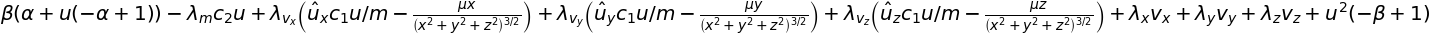

In [6]:
# Hamiltonian
H = l.dot(ds) + L
H

In [7]:
# minimise Hamiltonian w.r.t. controls
lv = Matrix(l[3:6])
uhs = -lv/sqrt(sum([var**2 for var in lv]))
uhs

⎡                   -\lambda_{v_x}                    ⎤
⎢─────────────────────────────────────────────────────⎥
⎢   __________________________________________________⎥
⎢  ╱              2                2                2 ⎥
⎢╲╱  \lambda_{v_x}  + \lambda_{v_y}  + \lambda_{v_z}  ⎥
⎢                                                     ⎥
⎢                   -\lambda_{v_y}                    ⎥
⎢─────────────────────────────────────────────────────⎥
⎢   __________________________________________________⎥
⎢  ╱              2                2                2 ⎥
⎢╲╱  \lambda_{v_x}  + \lambda_{v_y}  + \lambda_{v_z}  ⎥
⎢                                                     ⎥
⎢                   -\lambda_{v_z}                    ⎥
⎢─────────────────────────────────────────────────────⎥
⎢   __________________________________________________⎥
⎢  ╱              2                2                2 ⎥
⎣╲╱  \lambda_{v_x}  + \lambda_{v_y}  + \lambda_{v_z}  ⎦

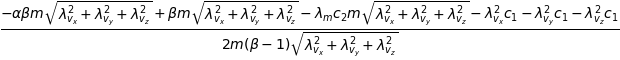

In [8]:
# new Hamiltonian
H1 = H.subs(ux, uhs[0]).subs(uy, uhs[1]).subs(uz, uhs[2])
ums = solve(H1.diff(um), um)[0]
ums

In [9]:
us = Matrix([[ums], uhs])
us

⎡                    __________________________________________________       
⎢                   ╱              2                2                2        
⎢- \alpha⋅\beta⋅m⋅╲╱  \lambda_{v_x}  + \lambda_{v_y}  + \lambda_{v_z}   + \bet
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [10]:
# costate equations of motion
dl = -H.diff(s)
dl

⎡                ⎛            2                        ⎞                      
⎢                ⎜     3⋅\mu⋅x               \mu       ⎟   3⋅\lambda_{v_y}⋅\mu
⎢- \lambda_{v_x}⋅⎜───────────────── - ─────────────────⎟ - ───────────────────
⎢                ⎜              5/2                 3/2⎟                    5/
⎢                ⎜⎛ 2    2    2⎞      ⎛ 2    2    2⎞   ⎟      ⎛ 2    2    2⎞  
⎢                ⎝⎝x  + y  + z ⎠      ⎝x  + y  + z ⎠   ⎠      ⎝x  + y  + z ⎠  
⎢                                                                             
⎢                                          ⎛            2                     
⎢  3⋅\lambda_{v_x}⋅\mu⋅x⋅y                 ⎜     3⋅\mu⋅y               \mu    
⎢- ─────────────────────── - \lambda_{v_y}⋅⎜───────────────── - ──────────────
⎢                   5/2                    ⎜              5/2                 
⎢     ⎛ 2    2    2⎞                       ⎜⎛ 2    2    2⎞      ⎛ 2    2    2⎞
⎢     ⎝x  + y  + z ⎠                       ⎝⎝x  + y 

In [11]:
Matrix([
    ums.subs(alpha, 0).subs(beta, 0),
    ums.subs(alpha, 0).subs(beta, 1),
    ums.subs(alpha, 1).subs(beta, 0),
    ums.subs(alpha, 1).subs(beta, 1),
    ums.subs(alpha, 0),
    ums.subs(alpha, 1),
    ums.subs(beta, 0),
    ums.subs(beta, 1),
    ums
])

⎡                                                                  ⎛          
⎢                                                                  ⎜          
⎢                                                                 -⎝- \lambda_
⎢                                                                 ────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                       ⎛                      _______________
⎢                                       ⎜                     ╱              2
⎢                                   zoo⋅⎝- \lambda_{m}⋅c₂⋅m⋅╲╱  \lambda_{v_x} 
⎢                                   ──────────────────────────────────────────
⎢                                                   

## Base trajectory

In [12]:
import sys, numpy as np, matplotlib.pyplot as plt, pygmo as pg, pykep as pk
sys.path.append('../src/')
from spacecraft import Spacecraft
from indirect import Indirect
%matplotlib

Using matplotlib backend: TkAgg


In [14]:
# instantiate problem
seg = Spacecraft(T=0.2, isp=2500, m=1000)

In [15]:
# initial state
s0 = np.hstack((*pk.planet.jpl_lp('earth').eph(pk.epoch(0)), seg.M))

# duration bounds in days
Tlb = 100
Tub = 500

# costates bounds
lb = 50

# homotopy parameters
alpha = 0
seg.beta = 0

In [17]:
zg = [447.85419003,   8.09073869,   1.11265495, -19.43475353, -5.54159539,  14.06194588,   5.62582364,  -4.86975254, 6.94011577]
z, f, feas = seg.solve(s0, 0, 100, 1000, 100, z=zg)
print(z, feas)

[447.85419002   8.09073869   1.11265494 -19.4347535   -5.54159539
  14.06194584   5.62582364  -4.86975254   6.94011577] True


In [18]:
tl, sl, ul = seg.propagate(z[0], s0, z[2:], 0, u=True)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


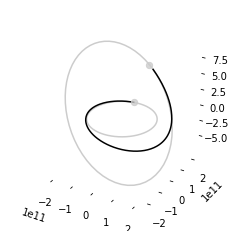

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pk.orbit_plots.plot_planet(
    pk.planet.jpl_lp('earth'), pk.epoch(6939.5), color=(0.8, 0.8, 0.8), ax=ax)
pk.orbit_plots.plot_planet(
    pk.planet.keplerian(pk.epoch(z[0]), pk.ic2par(sl[-1,0:3], sl[-1,3:6], seg.mu)),
    pk.epoch(z[0]), color=(0.8, 0.8, 0.8), ax=ax
)
ax.plot(sl[:,0], sl[:,1], sl[:,2], "k-")
ax.set_aspect('equal')
ax.grid('False')
# Get rid of the panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
plt.show()

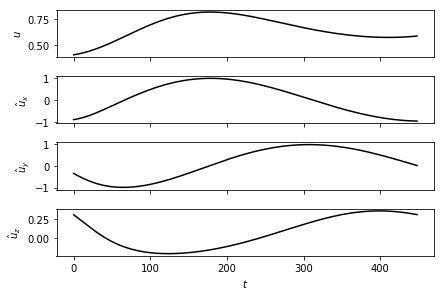

In [20]:
fig, ax = plt.subplots(4, sharex=True)
for dim in range(4):
    ax[dim].plot(tl, ul[:,dim], "k-")
fig.tight_layout()
ax[0].set_ylabel(r'$u$')
ax[1].set_ylabel(r'$\hat u_x$')
ax[2].set_ylabel(r'$\hat u_y$')
ax[3].set_ylabel(r'$\hat u_z$')
ax[3].set_xlabel(r'$t$')
plt.show()

# Policy homotopy